# Projeto de análise de custos em nuvem --- Hyperledger Fabric

Este projeto tem como objetivo auxiliar na predição de recursos necessários para executar uma blockchain Hyperledger Fabric --- ou outras blockchains permissionadas privadas com comportamento similar.</br>
Além dos recursos analisados, com base nos atributos de configuração e transações por segundo (TPS), disponibilizamos uma estimativa de custos para executar elementos de uma organização na computação em nuvem</br>
</br>
Assim, o projeto é dividido em duas grandes seções: Predição de recursos e Calculadora de Custos em um ambiente Cloud.</br><br>

Nas seções, existem blocos que serão demarcados por " 🔵 " para sinalizar um bloco de parametrização e variaveis que podem ser alteradas



# Blockchain Predict (predição dos recursos)

## Configurações
É importante destacar que o modelo é baseado em configurações e entradas do usuário. É recomendado o conhecimento mínimo sobre uma blockchain Hyperledger Fabric e alguns testes preliminares para popular alguns campos. </br>
Na célula abaixo, a estrutura de dados ```BlockchainParameters```representa a configuração e parâmetros reais do arquivo de configuração da blockchain.
 </br>

### BlockchainParameters:
 
 ```GenesisBlockSize``` : indica o espaço ocupado pelo bloco gênese (primeiro bloco ao criar uma nova blockchain). Geralmente carrega poucas informações e na maioria dos casos pode ser irrelevante: <br>
 Os parâmetros listados abaixo interferem diretamente no comportamento da blockchain e devem ser analisados conforme necessidade.

 ```BatchSize```: O BatchSize é composto por dois parâmetros limites para garantir os valores máximos de informações em um bloco da blockchain.
 - ```AbsoluteMaxBytes```: esse parâmetro representa em Bytes qual deve ser o gatilho para o fechamento do bloco, isso é, ao ser atingido o valor de informações, o bloco deve ser fechado e gerado um novo bloco na cadeia.
 - ```MaxMessageCount```: esse parâmetro indica a quantidade de mensagens, no caso, limite transações que podem inseridas dentro do bloco
 ```BatchTimeout```: quando nenhum dos indicadores acima atingir seu gatilho, o *BatchTimeout* busca garantir o tempo máximo para espera do bloco em aberto.
```EndorsementPolicy```: define as políticas da rede para endosso --- assinatura e validação inicial de algum *peer* ---  das transações. O Endosso é normalmente representado por equações lógicas como OR(A,B), AND(A,B) ou OR(A,B,C). Para incluir nos cálculos a quantidades de transações que um Peer deve assinar, consideramos a distribuição das transações de forma uniforme entre os Peers dadas as condições configuradas (desconsiderando o comportamento **forçado** do *clients* em submeter somente a um *peer* para endosso). Nos exemplos OR(A,B), AND(A,B) ou OR(A,B,C) as transações requerem o total de endossos de Peers, respectivamente, 1/2, 2/2 ou 1/3.
<br> 
<br> 

### Tamanhos e campos (*BlockHeaders* e *TransactionFields*)
Durante a execução das transações na blockchain, os campos e cabeçalhos são preenchidos demandando bytes a serem armazenados. Os campos listados abaixo são utilizados posteriormente os cálculos de armazenamento. <br><br>
Esses campos podem ser dimensionados com base no SmartContract executado com alguns experimentos para estimar o seu tamanho. Reccomendamos que utilize a ferramenta [Hyperledger Caliper](https://www.hyperledger.org/projects/caliper) para compor a análise.
Em suma, os campos de ```BlockHeaders``` são campos com valores definidos após o bloco ser encadeado. ```TransactionFields``` por outro lado são campos presentes em cada transação. <br><br>
Mais detalhes na [documentação](https://hyperledger-fabric.readthedocs.io/en/release-2.5/ledger/ledger.html) nas seções [BlockHeaders](https://hyperledger-fabric.readthedocs.io/en/release-2.5/_images/ledger.diagram.4.png)  e [TransactionFields](https://hyperledger-fabric.readthedocs.io/en/release-2.5/_images/ledger.diagram.5.png)


In [1]:
# { 🔵 }

CONF = {
  "BlockchainParameters": {
    "GenesisBlockSize": 0, 
    "BatchSize": {
      "AbsoluteMaxBytes": 10485760,  # Bytes
      "MaxMessageCount": 100000
    }, 
    "BatchTimeout": 600, #Seconds
  "EndorsementPolicy": 1/2,
  }, 

  "BlockHeaders": { # Bytes
    "MetadataSize": 64, 
    "HeaderSize": 128
  }, 

  "TransactionFields": {#Bytes
    "R4": 128, 
    "E4": 512, 
    "H4": 64, 
    "P4": 256, 
    "S4": 256
  },
  
}



In [2]:
# { 🔵 }
CLOUD_PRICING = {
    "Storage": {
      "Pricing": 0.045
    }, 
    "NetworkThroughput": {
      "Pricing": 0.01
    }, 
    "VirtualMachine": {
      "FilePricing": "./Amazon EC2 Instance Comparison.csv", #null requires insert manual values InstancesTypes
       "InstancesTypes": [
      # E.g:
      #   {"VCPU": 2,  "Pricing": 0.0388},
      #   {"VCPU": 4,  "Pricing": 0.0776},
      #   {"VCPU": 8,  "Pricing": 0.1552},
      #   {"VCPU": 16,  "Pricing": 0.3104},
       ]
      
    }, 
    "Additional": 0 # E.g: taxes or discounts
  }

In [3]:
#%matplotlib inline #<< É necessário utilizar se estiver no VSCODE

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import numpy as np
import pandas as pd

import pprint

In [4]:
#predict.py
TRANSACTION_SIZE     =  np.sum(np.array([fields_values for fields_values in CONF['TransactionFields'].values()]))
BLOCK_HEADERS_SIZE   =  np.sum(np.array([fields_values for fields_values in CONF['BlockHeaders'].values()]))

def calculate_size_total_transacoes(self, total_transactions:int, transation_size:int) -> int:
   self.size_total_transacoes = total_transactions * transation_size
   if self.size_total_transacoes > self.absolute_max_bytes:
      print('Undefined: size_total_transacoes > absolute_max_bytes')
      print('size_total_transacoes : ', self.size_total_transacoes)
      return -1
   return self.size_total_transacoes

class StorageDemand:
    def __init__(self):
        self.total_blocks = 0
        self.total_transactions = 0
        self.calculated_total_size_blocks = 0
        self.batch_type = ""
        self.period = 0

class CostPredict:
    def __init__(self):
        self.file_pricing                = CLOUD_PRICING['VirtualMachine']['FilePricing']
        self.instanc_types               = CLOUD_PRICING['VirtualMachine']['InstancesTypes']
        self.storage_pricing             = CLOUD_PRICING['Storage']['Pricing']
        self.network_throughput_pricing  = CLOUD_PRICING['NetworkThroughput']['Pricing']
        self.additional                  = CLOUD_PRICING['Additional']

In [5]:
def logistic_curve(t, P0, K, r, t0):
    return P0 + (K - P0) / (1 + np.exp(-r * (t - t0)))

### Modelagem da curva de adoção
Para uma modelagem mais abrangente, as predições são geradas com base no tipo período da variável ```PREDICT_TYPE``` que assume os valores de: 'DAY' para dias, 'WEEK' para semana, 'MONTH' para mês e YEAR' para anos. 
<br><br>
Há duas formas de inserir comportamentos estimados de transações por segundo no ambiente.
1. ARRAY: Inserir valores de TPS diretamente no Array 
2. Função Logística: Ajustar os parametros da função logística para gerar algum comportamento ao longo do período (**deixar o ARRAY vazio para auto seleção*)

A função de regressão logística pode simplificar na visualização e estimativas da adoção da tecnologia. Ainda que para uma organização em longo prazo seja díficil ter certeza sobre a demanda de transações, o gráfico da curva pode assumir diferentes comportamentos e auxiliar visualmente na modelagem.

In [6]:
# 🔵 Required PREDICT_TYPE

global PREDICT_TYPE
PREDICT_TYPE = 'MONTH' # 🔵 'DAY':'WEEK':'MONTH':'YEAR'

In [7]:
# 🔵 Caso array [vazio]
global AVG_RATE_TRANSACTIONS

ARRAY = []# 🔵 E.g [50,100,150,200,250,320,370,550,750,1000]
AVG_RATE_TRANSACTIONS = np.array(ARRAY)

In [8]:
# 🔵 Caso Função Logistica (default)

A = 120         # 🔵 Numero de periodos. E.g: para 18 meses => PREDICT_TYPE = 'MONTH' e A = 18 

t = np.linspace(0, A - 1, A)

# Parâmetros da curva logística
P0 = 5         # 🔵 Transações inicial
K = 1000       # 🔵 Valor máximo transações estimado
r =  0.15      # 🔵 Taxa de crescimento
t0 = A / 4     # 🔵 Ponto de inflexão -> Meio

# Calcula a população usando a função da curva logística

if len(ARRAY) == 0: # Ativar função logistica
    AVG_RATE_TRANSACTIONS = logistic_curve(t, P0, K, r, t0)



In [9]:
# Cod Auxiliar de plotagens
def simple_plot(x,y,line_label="", xlabel=f'Tempo ({PREDICT_TYPE})', ylabel="", title="", v_grid=True, tlabel_style="plain"):
    print(f'Ultimo valor "{line_label}" => {y[-1]}')
    fig, ax = plt.subplots()
    ax.plot(x,y,label=line_label)
    ax.ticklabel_format(style=tlabel_style)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(v_grid)
    return fig, ax

In [2]:
#Plotagem da curva de transações com base nas entradas
fig, ax = simple_plot(x= t,y= AVG_RATE_TRANSACTIONS, line_label= 'Transações por segundo', ylabel= 'Media de transações por segundo', title= 'Modelo de Crescimento Transações')
plt.show()

NameError: name 'simple_plot' is not defined

Ultimo valor "Exemplo 1" => 999.9346058835911


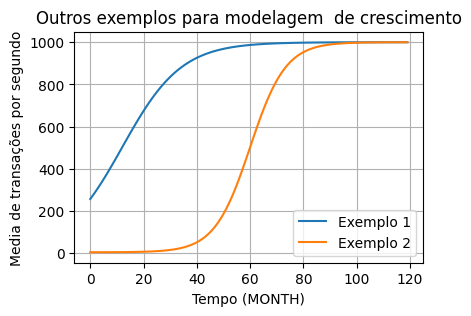

In [64]:
# Exemplos de modelagem auxiliar

A = 120         # Numero de periodos

t = np.linspace(0, A - 1, A)

# Parâmetros da curva logística
P0 = 5         # Transações inicial
K = 1000       # Valor máximo transações estimado
r =  0.09       # Taxa de crescimento
t0 = A/10     # Ponto de inflexão 

example_curve_1 = []
if len(ARRAY) == 0: # Ativar função logistica
    example_curve_1 = logistic_curve(t, P0, K, r, t0)

r =  0.15      # Taxa de crescimento
t0 = A/2     # Ponto de inflexão 
example_curve_2 = []
if len(ARRAY) == 0: # Ativar função logistica
    example_curve_2 = logistic_curve(t, P0, K, r, t0)




fig, ax = simple_plot(x= t,y= example_curve_1, line_label= 'Exemplo 1', ylabel= 'Media de transações por segundo', title= 'Outros exemplos para modelagem  de crescimento')
ax.plot(t, example_curve_2, label='Exemplo 2')
ax.legend()
fig.set_size_inches(4.5,3)
plt.show()



### Demanda de Armazenamento e Transações

**TRANSAÇÕES**

In [12]:

def expand_transations_by_period(predict_type, rate_transations_per_second):
    SECONDS_PER_DAY  = 86400
    return {
    'DAY': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY,
    'WEEK': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 7,
    'MONTH': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 30,
    'YEAR': lambda rate_transations_per_second: rate_transations_per_second * SECONDS_PER_DAY * 365
    }[predict_type](rate_transations_per_second)

total_transactions_by_period = expand_transations_by_period(PREDICT_TYPE, AVG_RATE_TRANSACTIONS)

In [13]:
endorsement_transations = total_transactions_by_period * CONF['BlockchainParameters']['EndorsementPolicy']

Plotagem da soma do total 'Transações (Commited)' no periodo apresenta uma expansão de transações por **segundo** para o período escolhido. Por exemplo, para um predição de DIA, dado o valor de X transações por segundo, a soma dessas transações equivalem a Y transações total no dia
<br>

💡 'Transações (Commited)' são aquelas gravadas na blockchain

Ultimo valor "Transações (Commited)" => 2591995892.0414505


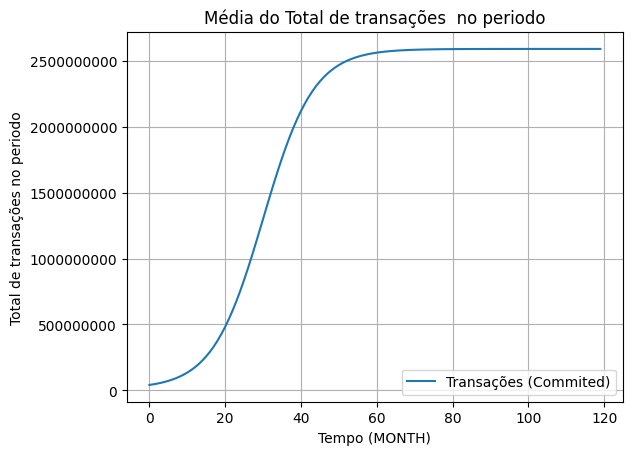

In [14]:
# Plotagem da soma do total transações estimada no periodo
fig, ax = simple_plot(x= t, y= total_transactions_by_period, line_label= 'Transações (Commited)', ylabel= 'Total de transações no periodo', title= 'Média do Total de transações  no periodo')
plt.show()

Plotagem da comparação 'Endorsement Transations' da rede em comparação ao total de transações *Commited* apresentado acima, com base no parametro ***EndorsementPolicy***
<br>
💡 'Endorsement Transations'  são aquelas que o peer deve pré-assinar para ser submetida na rede


Ultimo valor "Total Commited Transations" => 2591995892.0414505
Ultimo valor "Total Endorsement Transations" => 1295997946.0207253


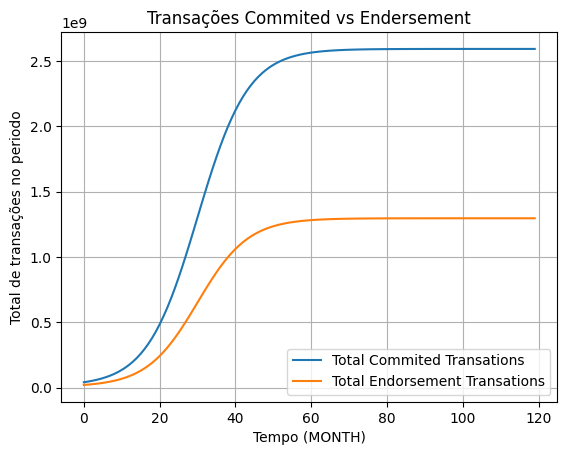

In [15]:
fig, ax = simple_plot(x= t, y= total_transactions_by_period, line_label='Total Commited Transations', ylabel= 'Total de transações no periodo', title= 'Transações Commited vs Endersement', tlabel_style='sci')
ax.plot(t, endorsement_transations, label='Total Endorsement Transations')
ax.legend()
print(f'Ultimo valor "Total Endorsement Transations" => {endorsement_transations[-1]}')

plt.show()

#### SEÇÃO COM A ESTIMATIVA DE GERAÇÃO DOS BLOCOS:
A quantidade de blocos tem impacto na rede, pois a quantidade de blocos multiplicado pelos [tamanhos de cabeçalho](#tamanhos-e-campos-blockheaders-e-transactionfields) será computado também no total de armazenamento.
<br>
Além disso, sabendo a quantidade de transações dentro de um bloco e o [tamanho de cada transação](#tamanhos-e-campos-blockheaders-e-transactionfields) podemos estimar o tamanho total do bloco, e cumulativamente o tamanho total da blockchain

In [16]:
# Bloco principal da análise de geração de blocos com base nas transações
def estimate_blocks(avg_tps, total_transations_period):
    total_blocks = None
    batch_type  = ""
    
    #Qual o tempo necessário para fechar um bloco para max_message
    time_to_batch_messages = CONF['BlockchainParameters']['BatchSize']['MaxMessageCount'] / avg_tps

    #Quantas transações são necessárias para fechar um bloco com max_bytes
    aggregate_total_transations_if_batch_max_bytes = CONF['BlockchainParameters']['BatchSize']['AbsoluteMaxBytes'] / TRANSACTION_SIZE
    time_to_batch_bytes  = aggregate_total_transations_if_batch_max_bytes / avg_tps

    total_blocks = None
    
    if time_to_batch_messages >= CONF['BlockchainParameters']['BatchTimeout']  and \
            time_to_batch_bytes >=  CONF['BlockchainParameters']['BatchTimeout'] :# calcular para encadeamento batchtimeout

        
        aggregate_total_transations_if_batch_timeout = CONF['BlockchainParameters']['BatchTimeout'] * avg_tps
        total_blocks = total_transations_period / aggregate_total_transations_if_batch_timeout
        batch_type = "batch_timeout"

    elif time_to_batch_messages < time_to_batch_bytes: # calcular para encadeamento batch messages
        total_blocks = total_transations_period / time_to_batch_messages
        batch_type = "batch_message"
        
    
    elif time_to_batch_bytes    < time_to_batch_messages:# calcular para encadeamento batch bytes
        total_blocks = total_transations_period / time_to_batch_bytes
        batch_type = "batch_bytes"
        
    else:
        raise Exception
        
    
    return total_blocks, batch_type

storage_demand = []
for i_period in range(0,A): 

    avg_t = AVG_RATE_TRANSACTIONS[i_period]
    total_transations_by_period = total_transactions_by_period[i_period]

    i_storage_demand = StorageDemand() # Salvar no objeto com atributos que serão utilizados posteriormente
    i_storage_demand.period                                         = i_period    
    i_storage_demand.total_transactions                             = total_transations_by_period
    i_storage_demand.total_blocks, i_storage_demand.batch_type      = estimate_blocks(avg_t, total_transations_by_period)
    i_storage_demand.calculated_total_size_blocks                   = (i_storage_demand.total_blocks * BLOCK_HEADERS_SIZE) + (i_storage_demand.total_transactions * TRANSACTION_SIZE)
    
    storage_demand.append(i_storage_demand)
    


In [17]:
i_period           = np.array([s.period for s in storage_demand])
cumulative_blocks  = np.cumsum( np.array([s.total_blocks for s in storage_demand]) )

Ultimo valor "Total de Blocos (cumulativo)" => 24918451397.479034


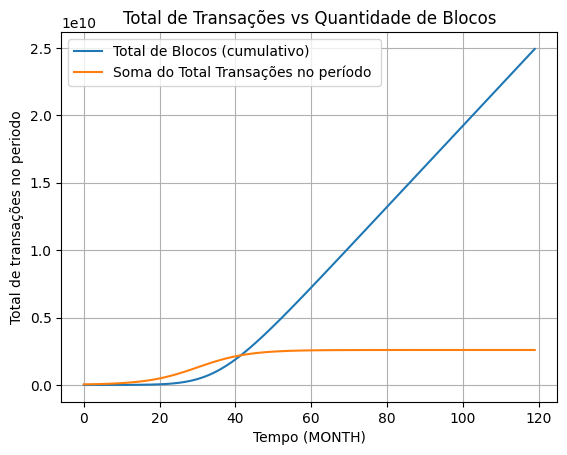

In [18]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = simple_plot(x= t, y= cumulative_blocks, line_label='Total de Blocos (cumulativo)', ylabel='Total de transações no periodo', title= 'Total de Transações vs Quantidade de Blocos', tlabel_style='sci')
ax.plot(t, total_transactions_by_period, label='Soma do Total Transações no período ')
ax.legend()
plt.show()

**ARMAZENAMENTO**

Com base nas informações do tamanho dos blocos, podemos estimar a demanda de armazenamento

In [19]:
BYTE_TO_GIGA =  pow(1024 , 3)
cumulative_size_GB  = np.cumsum( np.array([s.calculated_total_size_blocks for s in storage_demand]) /  BYTE_TO_GIGA )

BYTE_TO_TERA =  pow(1024 , 4)
cumulative_size_TB  = np.cumsum( np.array([s.calculated_total_size_blocks for s in storage_demand]) /  BYTE_TO_TERA )

Ultimo valor "Armazenamento GB" => 267423.13105843443


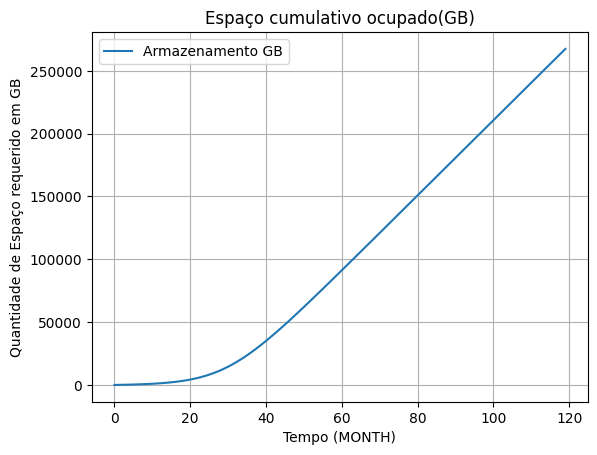

Ultimo valor "Armazenamento TB" => 261.1554014242524


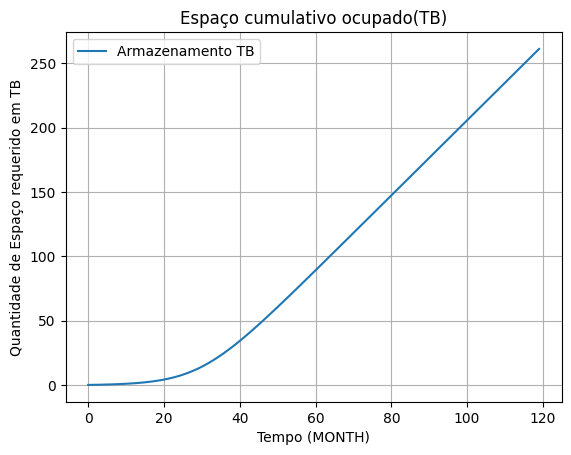

In [20]:
# ARMAZENAMENTO REQUERIDA GB / TB
fig, ax = simple_plot(x= t, y=cumulative_size_GB, line_label='Armazenamento GB', ylabel='Quantidade de Espaço requerido em GB', title= 'Espaço cumulativo ocupado(GB)', tlabel_style='plain')
plt.show()

fig, ax = simple_plot(x= t, y=cumulative_size_TB, line_label='Armazenamento TB', ylabel='Quantidade de Espaço requerido em TB', title= 'Espaço cumulativo ocupado(TB)', tlabel_style='plain')
plt.show()

### Demanda CPU

O consumo de CPU é estimado conforme a taxa de transações por segundo.
<br>
No entando, diferentes elementos da rede com seus diferentes workloads, necessitam processar quantidades e complexida de transações de forma independente.
Na arquitetura do Hyperledger Fabric, os elemenetos que compõem a rede das organizações majoriariamente são os peers, mas também podemos incluir um nodo resposável pela ordenação das transações



### Demanda CPU ~ Ordering Service

In [21]:
aggregate_total_required_vcpu_osn = np.array([])
vCPU_BASE_OSN     =  1
vCPU_BASE_TPS_OSN = 150 # 2vcpu = 200

ordering_transations = AVG_RATE_TRANSACTIONS

for tps in ordering_transations:
    target_required_vcpu  = vCPU_BASE_OSN

    required_vcpu_current_tps = tps / vCPU_BASE_TPS_OSN

    if int(required_vcpu_current_tps) > 1:
        target_required_vcpu = vCPU_BASE_OSN + (vCPU_BASE_OSN * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu_osn = np.append(aggregate_total_required_vcpu_osn, target_required_vcpu)

Ultimo valor "vCPU" => 7.0


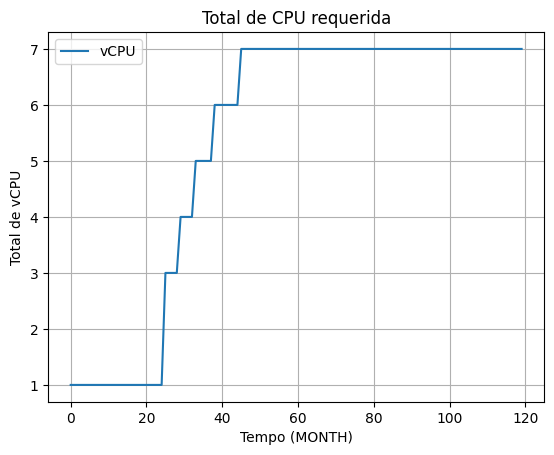

In [22]:
fig, ax = simple_plot(x= t, y=aggregate_total_required_vcpu_osn, line_label='vCPU', ylabel='Total de vCPU', title= 'Total de CPU requerida', tlabel_style='plain')
plt.show()

In [23]:
aggregate_total_required_vcpu_osn*vCPU_BASE_TPS_OSN

array([ 150.,  150.,  150.,  150.,  150.,  150.,  150.,  150.,  150.,
        150.,  150.,  150.,  150.,  150.,  150.,  150.,  150.,  150.,
        150.,  150.,  150.,  150.,  150.,  150.,  150.,  450.,  450.,
        450.,  450.,  600.,  600.,  600.,  600.,  750.,  750.,  750.,
        750.,  750.,  900.,  900.,  900.,  900.,  900.,  900.,  900.,
       1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050.,
       1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050.,
       1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050.,
       1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050.,
       1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050.,
       1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050.,
       1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050.,
       1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050., 1050.,
       1050., 1050., 1050.])

Ultimo valor "TPS vCPU " => 1050.0


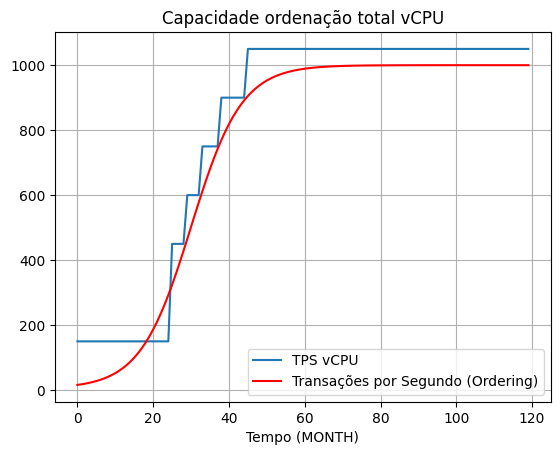

In [24]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = simple_plot(x= t, y=aggregate_total_required_vcpu_osn*vCPU_BASE_TPS_OSN, line_label='TPS vCPU ', ylabel='', title= 'Capacidade ordenação total vCPU', tlabel_style='plain')
ax.plot(t, ordering_transations, label='Transações por Segundo (Ordering)', color='red')
plt.legend()
plt.show()


## CPU PEER

In [25]:
aggregate_total_required_vcpu_peer = np.array([])
vCPU_BASE     =  2
vCPU_BASE_TPS = 200 # 2vcpu = 200

peer_commited_transations = AVG_RATE_TRANSACTIONS
peer_endorsement_transations = AVG_RATE_TRANSACTIONS * CONF['BlockchainParameters']['EndorsementPolicy']
peer_endorsement_commited_transations = peer_commited_transations + peer_endorsement_transations

for tps in peer_endorsement_commited_transations:
    target_required_vcpu  = vCPU_BASE

    required_vcpu_current_tps = tps / vCPU_BASE_TPS

    if int(required_vcpu_current_tps) > 1:
        target_required_vcpu = vCPU_BASE + (vCPU_BASE * int(required_vcpu_current_tps))
        
    aggregate_total_required_vcpu_peer = np.append(aggregate_total_required_vcpu_peer, target_required_vcpu)

/tmp/ipykernel_5204/1021050568.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


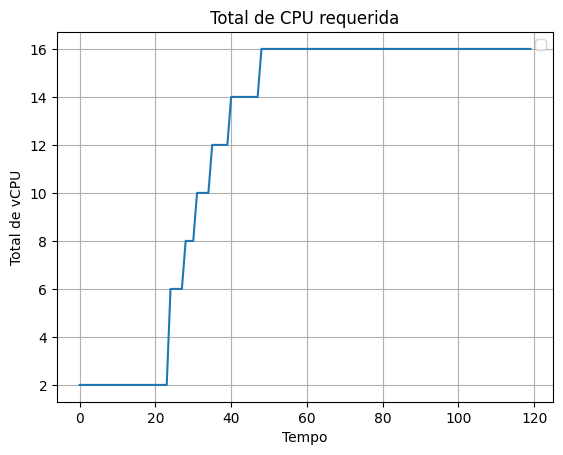

In [26]:
#
fig, ax = plt.subplots()
ax.plot(t, aggregate_total_required_vcpu_peer, label='')
ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida')
plt.legend()
plt.show()

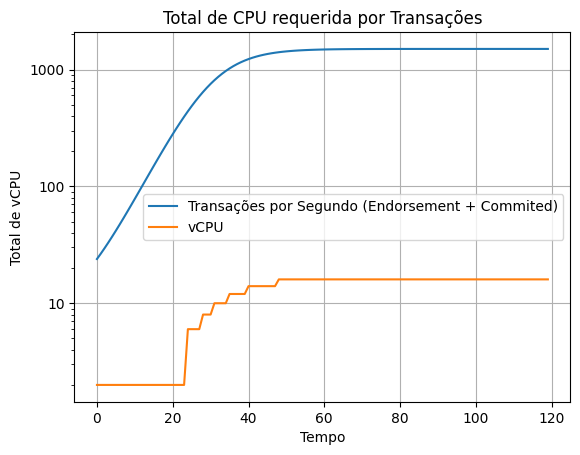

In [27]:
# Plotagem da soma do toal transações estimada no periodo
fig, ax = plt.subplots()

plt.semilogy(t, peer_endorsement_commited_transations, label='Transações por Segundo (Endorsement + Commited)')
plt.plot(t, aggregate_total_required_vcpu_peer, label='vCPU')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU requerida por Transações')
plt.legend()
plt.show()

# Cloud Costs

In [28]:
pprint.pprint(CLOUD_PRICING)

{'Additional': 0,
 'NetworkThroughput': {'Pricing': 0.01},
 'Storage': {'Pricing': 0.045},
 'VirtualMachine': {'FilePricing': './Amazon EC2 Instance Comparison.csv',
                    'InstancesTypes': []}}


### Storage 

Estimativas criadas a partir da calculadora AWS. 
É importante ressaltar que cloud providers consideram 730 horas mês,
 isso significa dizer que uma semana, é em média cobrada 730 * 0,25, o que resulta em 182,5 ao contrário de 7 * 24 = 168

A justificativa é porque isso consegue minimizar as divergencias de meses com 28,29,30,31 dias

[Ir para](##CPU-PEER)

In [29]:
def convert_period_month(predict_type): #BASED AWS CALCULATOR
    VOLUME_MONTH_HOURS  = 730
    return {
    'DAY'   : 30 / VOLUME_MONTH_HOURS, #0,04109...
    'WEEK'  : ( VOLUME_MONTH_HOURS / 4 ) / VOLUME_MONTH_HOURS, # 0,25
    'MONTH' : VOLUME_MONTH_HOURS / VOLUME_MONTH_HOURS, # 1
    'YEAR'  : (VOLUME_MONTH_HOURS / VOLUME_MONTH_HOURS) * 12, #12 
    }[predict_type]


convert_period_pricing_month = convert_period_month(PREDICT_TYPE)
print()
total_storage_cost = cumulative_size_GB * (CostPredict().storage_pricing  * convert_period_pricing_month)

12034.04089762955


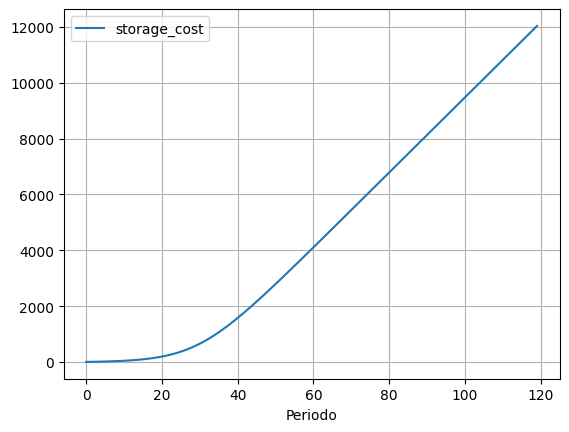

In [30]:
# Plotagem da soma do toal transações estimada no periodo
print(total_storage_cost[-1])
fig, ax = plt.subplots()
ax.plot(i_period, total_storage_cost, label='storage_cost')

ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Periodo')
plt.ylabel('')
plt.title('')
plt.legend()
plt.show()

In [31]:
# EC2
df = pd.read_csv('Amazon EC2 Instance Comparison.csv')
df['vCPUs'] = df['vCPUs'].str.replace(r'\D+', '', regex=True)
df['On Demand'] = df['On Demand'].str.replace(r'[^0-9.]', '', regex=True)

df['vCPUs'] = pd.to_numeric(df['vCPUs'])
df['On Demand'] = pd.to_numeric(df['On Demand'])

#instancias = df[(df['vCPUs'] > aggregate_total_required_vcpu_peer)]

In [32]:
df

,Name,API Name,Instance Memory,vCPUs,Instance Storage,Network Performance,On Demand
0,C6A Large,c6a.large,4.0 GiB,2,EBS only,Up to 12.5 Gigabit,0.0765
1,C6A Extra Large,c6a.xlarge,8.0 GiB,4,EBS only,Up to 12.5 Gigabit,0.1530
2,C6A Double Extra Large,c6a.2xlarge,16.0 GiB,8,EBS only,Up to 12.5 Gigabit,0.3060
3,C6A Quadruple Extra Large,c6a.4xlarge,32.0 GiB,16,EBS only,Up to 12.5 Gigabit,0.6120
4,C6A Eight Extra Large,c6a.8xlarge,64.0 GiB,32,EBS only,12.5 Gigabit,1.2240
5,C6A 12xlarge,c6a.12xlarge,96.0 GiB,48,EBS only,18.75 Gigabit,1.8360
6,C6A 16xlarge,c6a.16xlarge,128.0 GiB,64,EBS only,25 Gigabit,2.4480
7,C6A 24xlarge,c6a.24xlarge,192.0 GiB,96,EBS only,37.5 Gigabit,3.6720
8,C6A 32xlarge,c6a.32xlarge,256.0 GiB,128,EBS only,50 Gigabit,4.8960
9,C6A 48xlarge,c6a.48xlarge,384.0 GiB,192,EBS only,50 Gigabit,7.3440


In [33]:
def provisioned_instance_types(required_vcpu):
    provisioned_vcpu = np.array([])

    # Iterar sobre os elementos do array
    for vcpu in required_vcpu:
        # Verificar se o valor existe na coluna do DataFrame
        if vcpu in df['vCPUs'].values:
            # Se existir, adiciona o valor ao novo array
            type = df[(df['vCPUs'] == vcpu)].iloc[0].to_dict()
            provisioned_vcpu = np.append(provisioned_vcpu, type)
        else:
            # Se não existir, pega o valor mais próximo na coluna do DataFrame
            next_type = df[(df['vCPUs'] > vcpu)].iloc[0].to_dict()
            provisioned_vcpu = np.append(provisioned_vcpu, next_type)

    return provisioned_vcpu

In [34]:
provisioned_instance_peer = provisioned_instance_types(aggregate_total_required_vcpu_peer)
provisioned_instance_osn = provisioned_instance_types(aggregate_total_required_vcpu_osn)

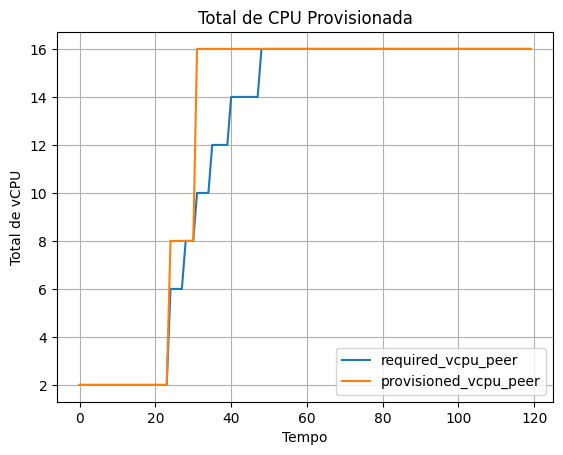

In [35]:
fig, ax = plt.subplots()

ax.plot(t, aggregate_total_required_vcpu_peer, label='required_vcpu_peer')

plot_provisioned_instance_peer = [x['vCPUs'] for x in provisioned_instance_peer]

ax.plot(t, plot_provisioned_instance_peer, label='provisioned_vcpu_peer')


ax.ticklabel_format(style='plain')
ax.grid(True)
plt.xlabel('Tempo')
plt.ylabel('Total de vCPU')
plt.title('Total de CPU Provisionada')
plt.legend()
plt.show()

In [36]:
def convert_period_hours(predict_type):
    
    return {
    'DAY': 24,
    'WEEK': 730 / 4,
    'MONTH': 730, # Providers consideram 730 por mes
    'YEAR': 730 * 12
    }[predict_type]

period_hours = convert_period_hours(PREDICT_TYPE)

cost_provisioned_instance_peer =  np.array([x['On Demand'] for x in provisioned_instance_peer])
cost_provisioned_instance_osn =  np.array([x['On Demand'] for x in provisioned_instance_osn])


computer_cost_period_peer   = cost_provisioned_instance_peer    * period_hours
computer_cost_period_osn    = cost_provisioned_instance_osn     * period_hours


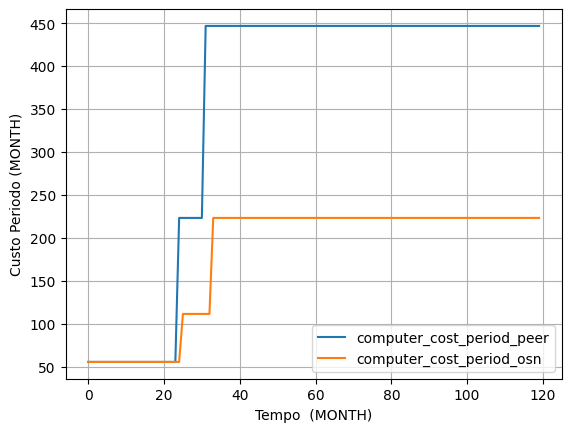

In [37]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, computer_cost_period_peer, label='computer_cost_period_peer')
plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

In [38]:
total_computer_cost_period = computer_cost_period_peer + computer_cost_period_osn

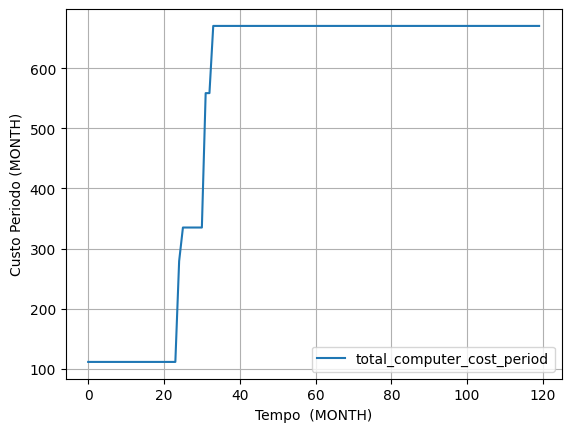

In [39]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_computer_cost_period, label='total_computer_cost_period')



ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

# Network

Considera que o peer e o ordering service estão na mesma rede </br>
pacotes de ack são desconsiderados Ex.: Code 200

In [40]:
transaction_size_gb                 = TRANSACTION_SIZE / BYTE_TO_GIGA
estimate_transaction_network_cost   = CLOUD_PRICING['NetworkThroughput']['Pricing'] * transaction_size_gb

network_tput_cost_clients_to_endorsement_peer   =  endorsement_transations * estimate_transaction_network_cost
network_tput_cost_clients_to_ordering_server    =  total_transactions_by_period * estimate_transaction_network_cost


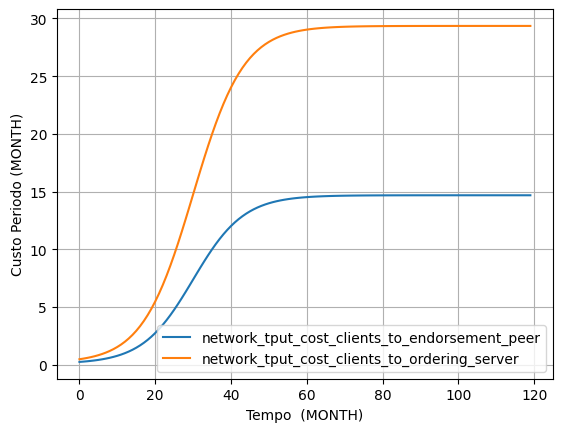

In [41]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, network_tput_cost_clients_to_endorsement_peer, label='network_tput_cost_clients_to_endorsement_peer')
plt.plot(t, network_tput_cost_clients_to_ordering_server, label='network_tput_cost_clients_to_ordering_server')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

In [42]:
total_network_throuput_cost = network_tput_cost_clients_to_ordering_server + network_tput_cost_clients_to_endorsement_peer


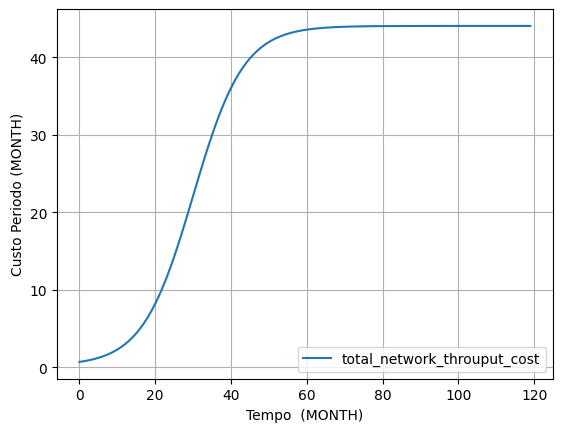

In [43]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_network_throuput_cost, label='total_network_throuput_cost')

ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()


# CUSTOS TOTAL

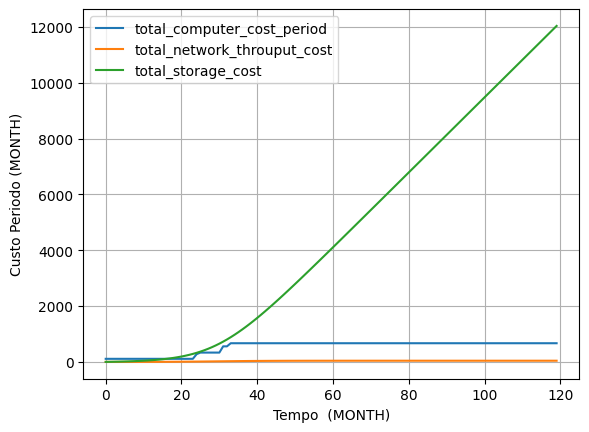

In [44]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_computer_cost_period, label='total_computer_cost_period')
plt.plot(t, total_network_throuput_cost, label='total_network_throuput_cost')
plt.plot(t, total_storage_cost, label='total_storage_cost')


ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

In [45]:
total_cost = total_computer_cost_period + total_network_throuput_cost + total_storage_cost

In [46]:
total_cost[-1]

12748.211971034803

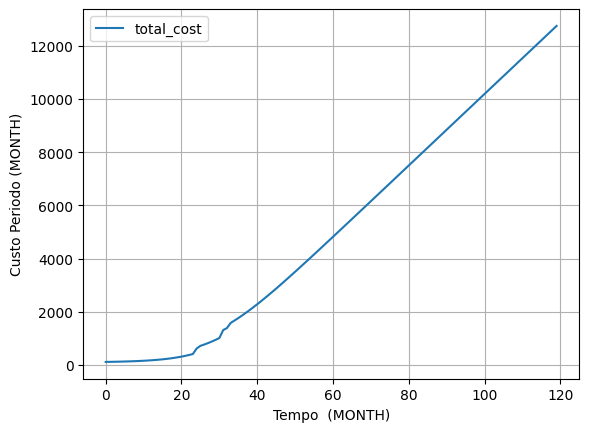

In [47]:
fig, ax = plt.subplots()
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
plt.plot(t, total_cost, label='total_cost')



ax.grid(True)
plt.xlabel(f'Tempo  ({PREDICT_TYPE})')
plt.ylabel(f'Custo Periodo ({PREDICT_TYPE})')
plt.title('')
plt.legend()
plt.show()

# ANOTAÇÕES 

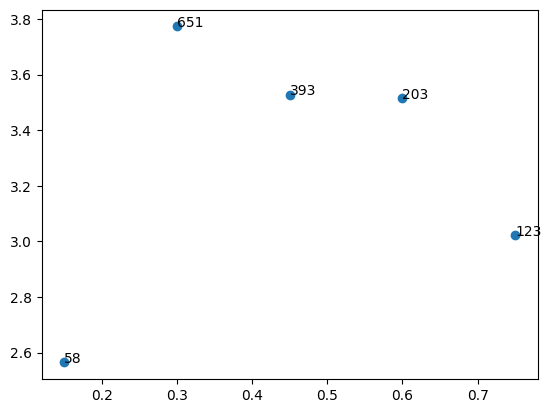

In [48]:
# Anotate
import matplotlib.pyplot as plt
x = [0.15, 0.3, 0.45, 0.6, 0.75]
y = [2.56422, 3.77284, 3.52623, 3.51468, 3.02199]
n = [58, 651, 393, 203, 123]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

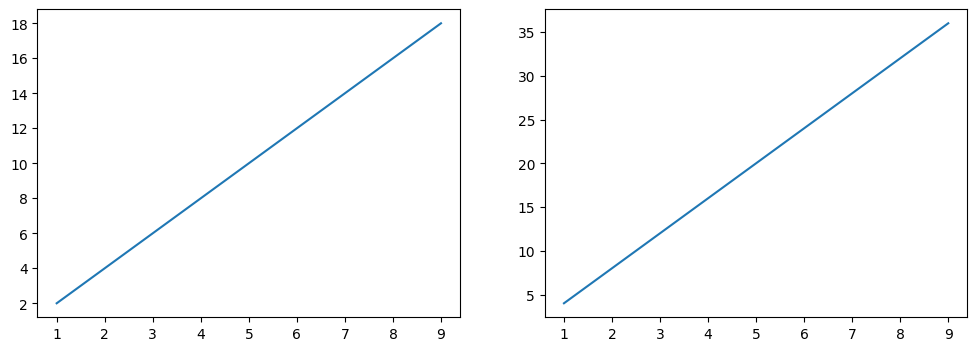

In [49]:
x = np.arange(1,10)
y = x *2 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
#plt.plot(t, computer_cost_period_osn, label='computer_cost_period_osn')
ax1.plot(x,y)

y = x *4 
ax2.plot(x,y)

plt.show()


### ToDo

<input type="checkbox" disabled />     Incluir verificação  não houver modelo com quantiadade de cpus suficiene ex.: Azure com até 72vcpu <br>
<input type="checkbox" disabled />     Tabelas para visualização dos dados do grafico <br>
<input type="checkbox" disabled />     Graficos de barra<br>
<input type="checkbox" disabled checked />     Verificar todas as metricas de calculo. Ex.: Storage /Mes. <br> 
<input type="checkbox" disabled checked />Network ok pois é por GB independente

### Links de plots
https://github.com/norvig/pytudes


Calculadora otimizada vs algo generico